In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [134]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [135]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [137]:
df = pd.read_csv('BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv', index_col='Date', parse_dates=True)

In [138]:
df['LogClosing Price (USD)'] = np.log(df['Closing Price (USD)'])

In [139]:
Ntest = 100
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [140]:
# Make supervised dataset
# let's see if we can use T past values to predict the next value

series = df['LogClosing Price (USD)'].to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2777, 10) Y.shape (2777,)


In [141]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [142]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
lr.score(Xtrain, Ytrain)

0.9991907150953536

In [143]:
lr.score(Xtest, Ytest)

0.8149840400645324

In [144]:
# Boolean index
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T] = False # first T values are not predictable

In [145]:
# 1-step forecast
df.loc[train_idx, 'LR_1step_train'] = lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = lr.predict(Xtest)

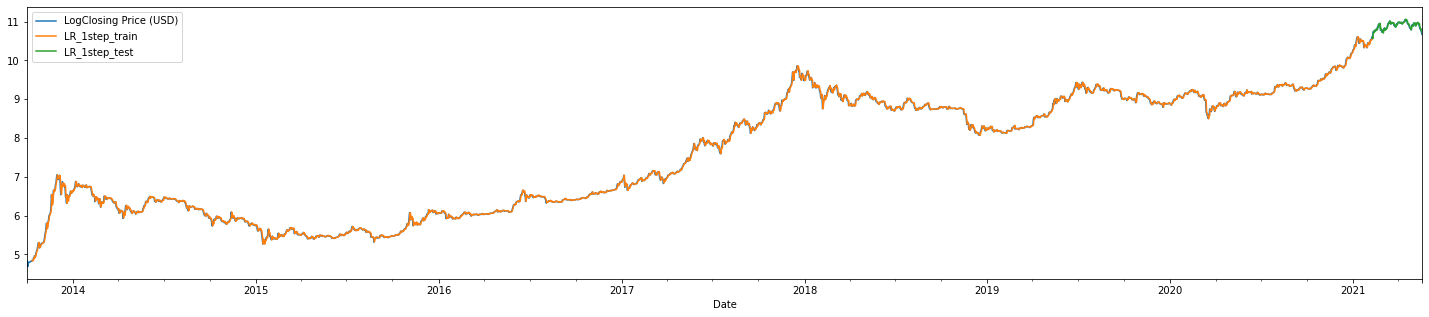

In [146]:
# plot 1-step forecast
df[['LogClosing Price (USD)', 'LR_1step_train', 'LR_1step_test']].plot(figsize=(25, 5));

In [147]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = lr.predict(last_x.reshape(1, -1))[0]
  
  # update the predictions list
  multistep_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

In [148]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'LR_multistep'] = multistep_predictions

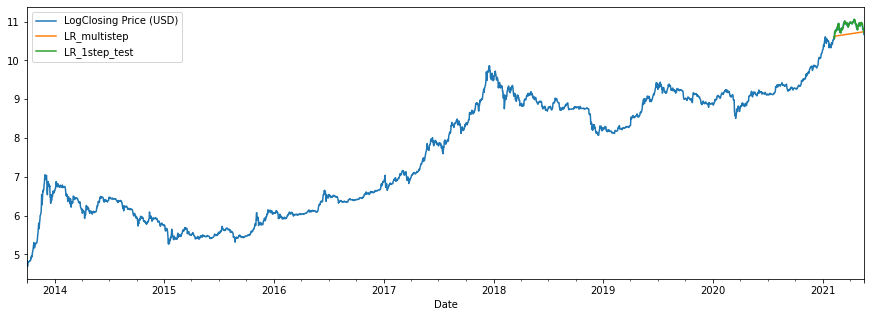

In [149]:
# plot 1-step and multi-step forecast
df[['LogClosing Price (USD)', 'LR_multistep', 'LR_1step_test']].plot(figsize=(15, 5));

In [150]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2678, 10) Y.shape (2678, 100)


In [151]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [152]:
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m)

0.9512277462311353

In [153]:
# SST is zero!
lr.score(Xtest_m, Ytest_m)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


nan

In [154]:
r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten())

-3.202159291607453

In [155]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'LR_multioutput'] = lr.predict(Xtest_m).flatten()

Text(0.5, 1.0, 'FORECAST FOR NEXT 100 DAYS linear regression(no differencing) multi-step MAPE: 0.0195,multi-output MAPE: 0.0134')

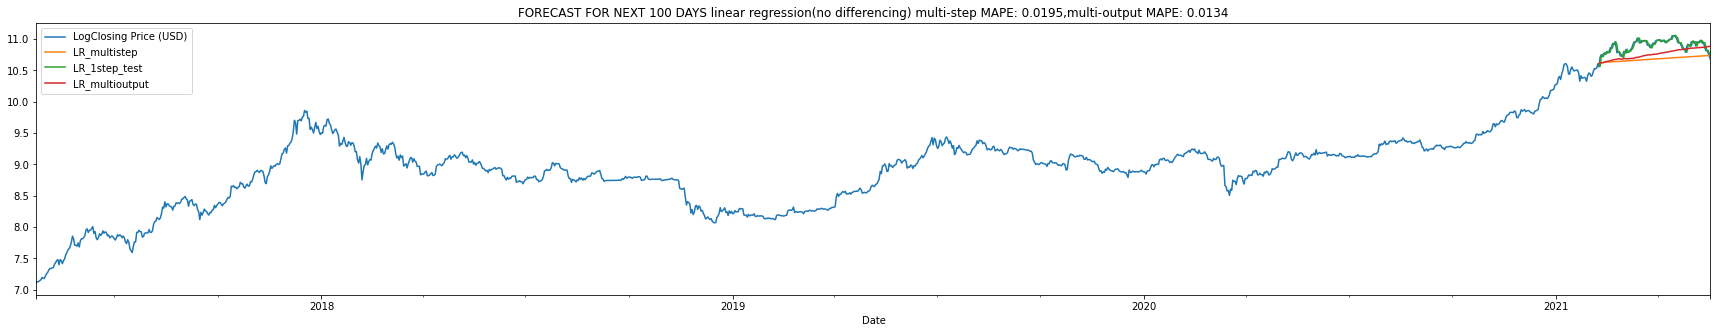

In [165]:
# plot all forecasts
cols = ['LogClosing Price (USD)', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']
df[cols][1300:].plot(figsize=(30, 5));
plt.title("FORECAST FOR NEXT 100 DAYS linear regression(no differencing) multi-step MAPE: 0.0195,multi-output MAPE: 0.0134")

In [157]:
# MAPE
mape1 = mean_absolute_percentage_error(Ytest, multistep_predictions)
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    Ytest, df.loc[test_idx, 'LR_multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.019514179116280603
multi-output MAPE: 0.013435047614888068


## Test Other Models

In [158]:
def one_step_and_multistep_forecast(model, name):
  model.fit(Xtrain, Ytrain)
  print("One-step forecast:", name)
  # print("Train R^2:", model.score(Xtrain, Ytrain))
  # print("Test R^2 (1-step):", model.score(Xtest, Ytest))

  # store 1-step forecast
  df.loc[train_idx, f'{name}_1step_train'] = model.predict(Xtrain)
  df.loc[test_idx, f'{name}_1step_test'] = model.predict(Xtest)

  # generate multi-step forecast
  multistep_predictions = []

  # first test input
  last_x = Xtest[0]

  while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1))[0]
    
    # update the predictions list
    multistep_predictions.append(p)
    
    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p
  
  # store multi-step forecast
  df.loc[test_idx, f'{name}_multistep_test'] = multistep_predictions

  # MAPE of multi-step forecast
  mape = mean_absolute_percentage_error(Ytest, multistep_predictions)
  print("Test MAPE (multi-step):", mape)

  # plot 1-step and multi-step forecast
  cols = [
    'LogClosing Price (USD)',
    f'{name}_1step_train',
    f'{name}_1step_test',
    f'{name}_multistep_test'
  ]
  df[cols][1300:].plot(figsize=(30, 5));

One-step forecast: SVR
Test MAPE (multi-step): 0.04568410484324832


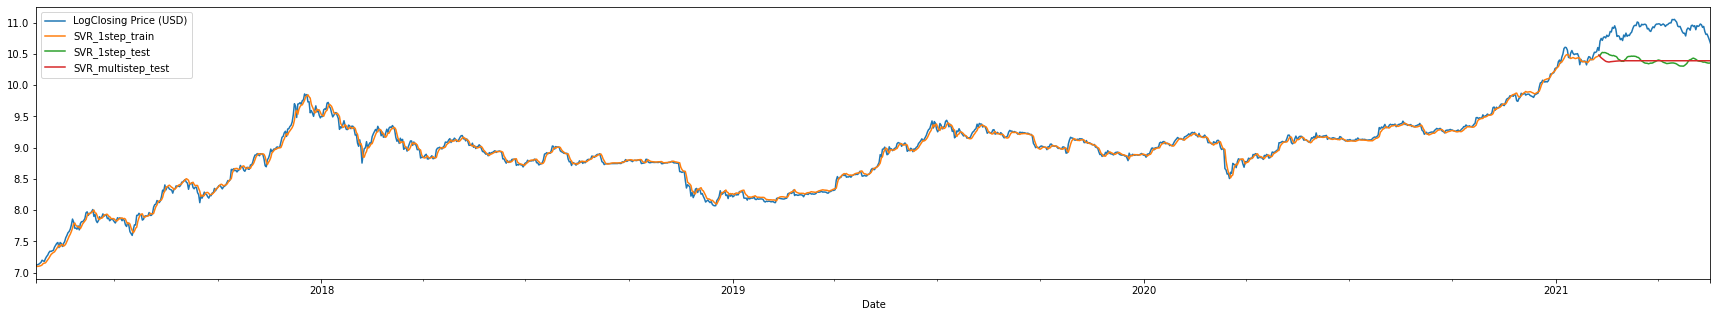

In [159]:
one_step_and_multistep_forecast(SVR(), "SVR")

One-step forecast: RF
Test MAPE (multi-step): 0.03653889931002265


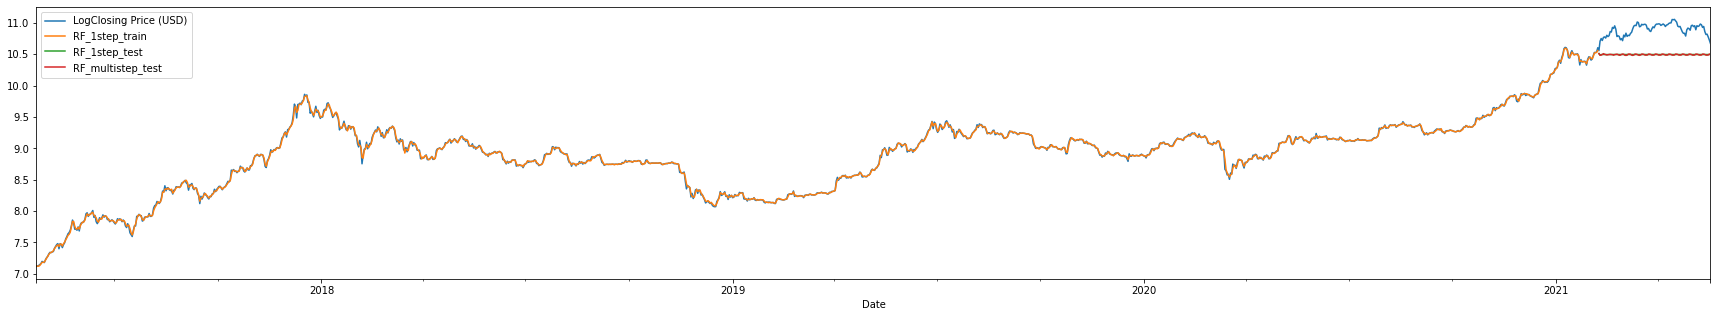

In [160]:
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

In [161]:
def multi_output_forecast(model, name):
  model.fit(Xtrain_m, Ytrain_m)
  
  # save multi-output forecast to dataframe
  df.loc[test_idx, f'{name}_multioutput'] = model.predict(Xtest_m).flatten()

  mape = mean_absolute_percentage_error(
      Ytest, df.loc[test_idx, f'{name}_multioutput'])
  print("Test MAPE (multi-output):", mape)

  # plot all forecasts
  # assume that previous functions have been run
  cols = [
    'LogClosing Price (USD)',
    f'{name}_1step_train',
    f'{name}_1step_test',
    f'{name}_multistep_test',
    f'{name}_multioutput',
  ]
  df[cols][1300:].plot(figsize=(30, 5));

In [162]:
multi_output_forecast(SVR(), "SVR") # cannot handle multi-output!
# But: you can still train multiple separate SVRs

ValueError: ignored

Test MAPE (multi-output): 0.009536308806900585


Text(0.5, 1.0, 'FORECAST FOR NEXT 100 DAYS  random forest (no differencing) multi-step MAPE: 0.0362,multi-output MAPE: 0.008')

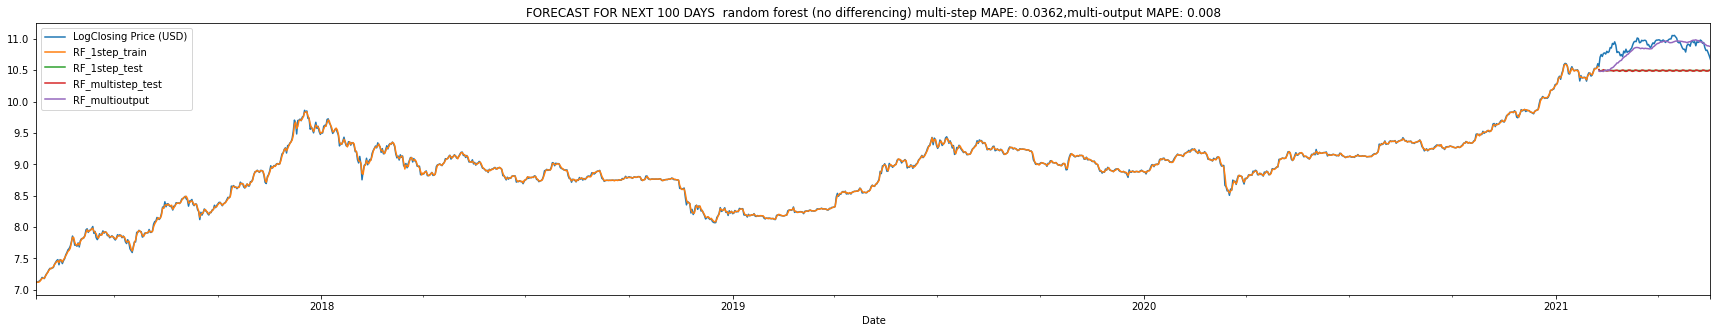

In [163]:
multi_output_forecast(RandomForestRegressor(), "RF")
plt.title("FORECAST FOR NEXT 100 DAYS  random forest (no differencing) multi-step MAPE: 0.0362,multi-output MAPE: 0.008")